In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import shutil
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, leaves_list


In [2]:
project_folder = '/Users/omer/Library/Mobile Documents/com~apple~CloudDocs/00-iCloud_Desktop/002 - LLM/00- Thesis/08 - Thesis Python'

dataset = project_folder + '/chapter_v_all_charters/05_final_dataset_merger/final_dataset.csv'

# Read the DataFrame before conducting the bucket and super-bucket calculations
df = pd.read_csv(
    os.path.join(
        dataset
    ),
    index_col=0
)

onedrive_path = '/Users/omer/Library/CloudStorage/OneDrive-Personal/Documents OneDrive/Omer_Mac/Word_Backup/master_table.xlsx'

db_for_processing = project_folder + '/db_for_processing.xlsx'

# Always overwrite local copy to ensure freshness
shutil.copy2(onedrive_path, db_for_processing) 

df = df.copy()

df.head()

,year,document_id,concise_name,document_type,venture_type,primary_purpose,colony_royal_takeover_year_start,colony_royal_takeover_year_end,territory,territory_group,...,institutional_limitation,limits_royal_prerogative,crown_reservation,subjection_to_english_law,royal_review_required,crown_oath_required,royal_imposed_limitation,procedural_powers,veto_powers,imposed_institutional_veto
0,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
group_by_cols_charter_level = [
    'year', 'document_id', 'concise_name', 'document_type', 'venture_type',
    'primary_purpose', 'colony_royal_takeover_year_start', 'colony_royal_takeover_year_end', 
    'territory', 'territory_group'
]

group_by_cols_institution_level = [
    'institution', 'institution_title_group', 'institution_subjection', 'institution_seat'
]

# Identify remaining columns to aggregate (likely 0/1 indicators)
aggregatable_cols = [
    col for col in df.columns 
    if col not in group_by_cols_charter_level + group_by_cols_institution_level
]

# Define your aggregation strategy: 'max' for 0/1 flags, 'first' for metadata
agg_dict = {col: 'max' for col in aggregatable_cols}

# Run grouped aggregation
df_grouped = (
    df
    .groupby(group_by_cols_charter_level, dropna=False)  # ensures NaNs don't collapse
    .agg(agg_dict)
    .reset_index()
)

# Drop institution-level columns if they exist (though grouping excluded them already)
df_grouped = df_grouped.drop(columns=[col for col in group_by_cols_institution_level if col in df_grouped.columns], errors='ignore')

df_grouped


,year,document_id,concise_name,document_type,venture_type,primary_purpose,colony_royal_takeover_year_start,colony_royal_takeover_year_end,territory,territory_group,...,institutional_limitation,limits_royal_prerogative,crown_reservation,subjection_to_english_law,royal_review_required,crown_oath_required,royal_imposed_limitation,procedural_powers,veto_powers,imposed_institutional_veto
0,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1578,GIL1578,The Letters Patent to Sir Humphrey Gilbert,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1584,RAL1584,Letters Patent to Walter Raleigh,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1592,LE1592,The Charter of the Levant Company,royal_charter,regulated_company,trade,NaN,NaN,levant_mediterranean,4,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1600,EIC1600,The Charter of the English East India Company,royal_charter,joint_stock,trade,NaN,NaN,east_indies,4,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1606,VA1606,The First Charter of Virginia,royal_charter,joint_venture,settlement,1624.0,NaN,north_america,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,1609,EIC1609,Renewal Charter of the English East India Company,royal_charter,joint_stock,trade,NaN,NaN,east_indies,4,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7,1609,VA1609,The Second Charter of Virginia,royal_charter,joint_stock,settlement,1624.0,NaN,north_america,1,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
8,1610,NL1610,The Charter of the Newfoundland Company,royal_charter,joint_stock,settlement,NaN,NaN,north_america,3,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1612,VA1612,The Third Charter of Virginia,royal_charter,joint_stock,settlement,1624.0,NaN,north_america,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Now, calculations of the buckets:

In [4]:
df_bucket = pd.read_excel(db_for_processing, sheet_name='buckets')

In [5]:
# Copy the grouped DataFrame
new_df = df_grouped.copy()

# Step 1: Build a mapping: {bucket → {variable → rational_score}}
from collections import defaultdict

bucket_scores = defaultdict(dict)
for _, row in df_bucket.iterrows():
    variable = row['Variables']
    bucket = row['Bucket']
    score = row['Rational Score']
    bucket_scores[bucket][variable] = score

# Step 2: Add one column per bucket in new_df, initialized to 0.0
for bucket in bucket_scores:
    new_df[bucket] = 0.0

# Step 3: For each row, calculate total score per bucket, with silent discounts (because of carryover provisions)
# and add to the corresponding bucket column
# Define the discount factor for silent carryover provisions
discount_factor = 0.75

for index, row in new_df.iterrows():
    for bucket, variables in bucket_scores.items():
        bucket_total = 0.0

        for variable, rational_score in variables.items():
            if variable in new_df.columns:
                value = row[variable]
                if value == 1:
                        # Determine whether this right was inferred via a silent carryover clause
                    is_silent = (
                        # Check if the row is marked as having silent carryover provisions
                        row.get("silent_carryover_provisions", 0) == 1 and

                        # Ensure that the silent_carryover_provisions_explanation field exists and is a string
                        isinstance(row.get("silent_carryover_provisions_explanation", ""), str) and
                        # Check if the current variable (i.e., right) appears in the comma-separated list of silent rights
                        variable in [x.strip() for x in row["silent_carryover_provisions_explanation"].split(",")]
                    )
                    if is_silent:
                        print(f"Silent carryover provisions found for {row['institution_title_group'],variable} in row {index}")
                    # If the right is silent, apply a discount (e.g., 50%) to its rational score
                    # Otherwise, apply the full score
                    adjusted_score = rational_score * (discount_factor if is_silent else 1.0)
                    # Add this adjusted score to the running total for the current bucket
                    bucket_total += adjusted_score

        new_df.at[index, bucket] = bucket_total


new_df.head()

,year,document_id,concise_name,document_type,venture_type,primary_purpose,colony_royal_takeover_year_start,colony_royal_takeover_year_end,territory,territory_group,...,Crown Tax Delegation,Economic & Fiscal Rights,Governance & Administration,Institutional Limitations,Institutional Limitation on Legislation,Royal Limitation on Legislation,Military & Security Powers,Settler & Subjects Rights,Territorial & Settlement Rights,Investor and Settler Voting Rights (Excluding Officeholders)
0,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.0,0.666667,0.588235,0.000000,0.0,0.25,0.4,0.5,1.0,0.0
1,1578,GIL1578,The Letters Patent to Sir Humphrey Gilbert,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.0,0.666667,0.235294,0.000000,0.0,0.25,1.0,0.5,1.0,0.0
2,1584,RAL1584,Letters Patent to Walter Raleigh,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.0,0.666667,0.235294,0.000000,0.0,1.00,1.0,0.5,1.0,0.0
3,1592,LE1592,The Charter of the Levant Company,royal_charter,regulated_company,trade,NaN,NaN,levant_mediterranean,4,...,0.0,0.733333,0.588235,0.285714,0.0,0.25,0.0,0.5,0.0,0.5
4,1600,EIC1600,The Charter of the English East India Company,royal_charter,joint_stock,trade,NaN,NaN,east_indies,4,...,0.0,0.733333,0.647059,0.285714,0.0,0.25,0.0,0.5,0.0,0.5


Now cross-buckets


In [6]:
df_cross_bucket = pd.read_excel(db_for_processing, sheet_name='super_buckets')

In [7]:
grouped = df_cross_bucket.groupby('Super_Buckets')

for cb_name, group in grouped:
    # Get plus and minus buckets
    plus_buckets = group['Bucket_Plus'].dropna().tolist()
    minus_buckets = group['Bucket_Minus'].dropna().tolist()

    # Create the column in new_df
    new_df[cb_name] = 0.0

    for index, row in new_df.iterrows():
        plus_score = sum(row.get(bucket, 0) for bucket in plus_buckets)
        minus_score = sum(row.get(bucket, 0) for bucket in minus_buckets)

        denom = len(plus_buckets) + len(minus_buckets)
        new_df.at[index, cb_name] = (plus_score - minus_score) / denom if denom else 0

new_df.head()

,year,document_id,concise_name,document_type,venture_type,primary_purpose,colony_royal_takeover_year_start,colony_royal_takeover_year_end,territory,territory_group,...,Autonomy (Officers),Autonomy Crown (Officers),Autonomy Crown&Inst. (Officers),Autonomy Inst. (Officers),Autonomy from Crown (Settlers),Autonomy from Crown (Shareholders),Gov. Auto. Crown (Officers),Legis. Auto. Crown (Officers),Legis. Auto. Crown&Inst. (Officers),Legis. Auto. Inst. (Officers)
0,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.196078,0.147059,0.117647,0.147059,0.2500,0.3750,0.294118,0.375,0.4375,0.5
1,1578,GIL1578,The Letters Patent to Sir Humphrey Gilbert,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.115468,-0.038399,-0.030719,0.086601,0.0000,-0.2500,-0.132353,0.375,0.4375,0.5
2,1584,RAL1584,Letters Patent to Walter Raleigh,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.115468,-0.132149,-0.105719,0.086601,-0.1875,-0.4375,-0.319853,0.000,0.2500,0.5
3,1592,LE1592,The Charter of the Levant Company,royal_charter,regulated_company,trade,NaN,NaN,levant_mediterranean,4,...,0.196078,0.022059,-0.039496,0.075630,0.0000,0.2500,0.044118,0.375,0.4375,0.5
4,1600,EIC1600,The Charter of the English East India Company,royal_charter,joint_stock,trade,NaN,NaN,east_indies,4,...,0.326797,0.245098,0.138936,0.173669,0.2500,0.5000,0.323529,0.375,0.4375,0.5


In [8]:
new_df.to_excel("charter_level_processed_db_all_charters_WITH_cols.xlsx", index=False)

In [9]:
# Drop the columns that are not needed
# List of columns to drop   

cols_to_drop_va_ma = """
precedent_clause_charter	prior_rights_savings_clause	silent_carryover_provisions 
silent_carryover_provisions_explanation territorial_rights	procedural_powers
veto_powers	settlement_rights	resource_rights	trade_rights	defense_rights	martial_law_rights
property_rights	fundraising_rights	exemption_rights	exclusivity_rights	civil_and_religious_rights
governance_rights	lawmaking_rights	judicial_powers	court_creation_rights disciplinary_jurisdiction	corporate_investor_rights
legal_entity_rights	litigation_rights	investor_voting_right	settler_voting_rights	officer_appointment_rights
officer_removal_rights	delegation_rights	membership_admission_rights	membership_expulsion_rights
imposed_institutional_veto	institutional_autonomy_rights	corporate_oath_required	office_oath_required
oath_administration_rights	legal_transplantation	favor_interpretation_ambiguity_grantee	crown_obligation
institutional_limitation	limits_royal_prerogative	crown_reservation	subjection_to_english_law
royal_review_required	crown_oath_required	royal_imposed_limitation	crown_taxation
""".split()

cols_to_drop = [x for x in cols_to_drop_va_ma if x in new_df.columns]

# Clean any whitespace from each column name
cols_to_drop = [col.strip() for col in cols_to_drop]

# Drop the columns
new_df_no_cols = new_df.drop(columns=cols_to_drop, errors="raise")

new_df_no_cols.to_excel("charter_level_processed_db_all_charters_NO_cols.xlsx", index=False)

new_df_no_cols.head()

,year,document_id,concise_name,document_type,venture_type,primary_purpose,colony_royal_takeover_year_start,colony_royal_takeover_year_end,territory,territory_group,...,Autonomy (Officers),Autonomy Crown (Officers),Autonomy Crown&Inst. (Officers),Autonomy Inst. (Officers),Autonomy from Crown (Settlers),Autonomy from Crown (Shareholders),Gov. Auto. Crown (Officers),Legis. Auto. Crown (Officers),Legis. Auto. Crown&Inst. (Officers),Legis. Auto. Inst. (Officers)
0,1555,RU1555,The Charter of the Russia Company,royal_charter,joint_stock,trade,NaN,NaN,russia,4,...,0.196078,0.147059,0.117647,0.147059,0.2500,0.3750,0.294118,0.375,0.4375,0.5
1,1578,GIL1578,The Letters Patent to Sir Humphrey Gilbert,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.115468,-0.038399,-0.030719,0.086601,0.0000,-0.2500,-0.132353,0.375,0.4375,0.5
2,1584,RAL1584,Letters Patent to Walter Raleigh,royal_charter,proprietary_colony,settlement,NaN,NaN,north_america,3,...,0.115468,-0.132149,-0.105719,0.086601,-0.1875,-0.4375,-0.319853,0.000,0.2500,0.5
3,1592,LE1592,The Charter of the Levant Company,royal_charter,regulated_company,trade,NaN,NaN,levant_mediterranean,4,...,0.196078,0.022059,-0.039496,0.075630,0.0000,0.2500,0.044118,0.375,0.4375,0.5
4,1600,EIC1600,The Charter of the English East India Company,royal_charter,joint_stock,trade,NaN,NaN,east_indies,4,...,0.326797,0.245098,0.138936,0.173669,0.2500,0.5000,0.323529,0.375,0.4375,0.5


### Embedding Cosine Similarity - Charter Level (BUCKET-Score! level)

In [10]:
# Preparing the dataset for analysis

df_anaylsis = new_df_no_cols.copy()

# Only corporate ventures are relevant for Corporate & Membership Rights bucket
corporate_ventures = ['joint_stock','corporate_venture','regulated_company']

for index, row in df_anaylsis.iterrows():
    for vent in corporate_ventures:
        if row['venture_type'] != vent:
            df_anaylsis.at[index, 'Corporate & Membership Rights'] = 0
        else:
            pass

# Due to focusing on charter level analysis, there's now way to isolate litigation & property rights granted specifically to settlers & subjects
df_anaylsis.drop(columns=['Settler & Subjects Rights'], inplace=True)

# Dropping cross-bucket provisions since they are not relevant for charter level analysis (they are designated for institution level anaylsis)
cross_bucket_mapping = {
    "Autonomy of Officers from Crown and institutional limitations": "Autonomy Crown&Inst. (Officers)",
    "Autonomy of Officers from Crown": "Autonomy Crown (Officers)",
    "Autonomy of Officers from institutional limitations": "Autonomy Inst. (Officers)",
    "Autonomy of Officers": "Autonomy (Officers)",
    "Lawmaking Autonomy from institutional limitations": "Legis. Auto. Inst. (Officers)",
    "Lawmaking Autonomy from Crown": "Legis. Auto. Crown (Officers)",
    "Lawmaking Autonomy from Crown and institutional limitations": "Legis. Auto. Crown&Inst. (Officers)",
    "Governance Autonomy from Crown": "Gov. Auto. Crown (Officers)",
    "Autonomy of Shareholders from Crown": "Autonomy from Crown (Shareholders)",
    "Autonomy of Settlers from Crown": "Autonomy from Crown (Settlers)"
}

cross_buckets_vars = [cross_bucket_mapping[x] for x in cross_bucket_mapping]

df_anaylsis.drop(columns=cross_buckets_vars, inplace=True)

# Dropping binary variables that are not relevant for charter level analysis focusing on bucket scores
binary_vars = ['lawmaking_participation_joint',
    'binary_judicial_powers',
    'binary_lawmaking_rights',
    'binary_property_rights',
    'binary_governance_rights',
    'binary_litigation_rights',
    'binary_veto_powers',
    'binary_lawmaking_participation_joint'
    ]

df_anaylsis.drop(columns=binary_vars,inplace=True)

# Finally, dropping metadate not relevant for embedding analysis (document_id is the only metadata relevant for embedding analysis)
df_anaylsis.set_index('document_id', inplace=True)
df_anaylsis.drop(columns=[x for x in group_by_cols_charter_level if x != 'document_id'], inplace=True)

df_anaylsis.head()

,Autonomy-Enhancing Provisions,Corporate & Membership Rights,Crown Oversight and Obligations,Crown Tax Delegation,Economic & Fiscal Rights,Governance & Administration,Institutional Limitations,Institutional Limitation on Legislation,Royal Limitation on Legislation,Military & Security Powers,Territorial & Settlement Rights,Investor and Settler Voting Rights (Excluding Officeholders)
document_id,,,,,,,,,,,,
RU1555,0.000000,0.0,0.000,0.0,0.666667,0.588235,0.000000,0.0,0.25,0.4,1.0,0.0
GIL1578,0.111111,0.0,0.500,0.0,0.666667,0.235294,0.000000,0.0,0.25,1.0,1.0,0.0
RAL1584,0.111111,0.0,0.875,0.0,0.666667,0.235294,0.000000,0.0,1.00,1.0,1.0,0.0
LE1592,0.000000,0.0,0.500,0.0,0.733333,0.588235,0.285714,0.0,0.25,0.0,0.0,0.5
EIC1600,0.333333,0.0,0.000,0.0,0.733333,0.647059,0.285714,0.0,0.25,0.0,0.0,0.5


In [11]:
# Step 1: Extract the matrix of doctrinal bucket scores
X = df_anaylsis.values  # must be numeric only

# Step 2: Compute cosine similarity
similarity_matrix = cosine_similarity(X)

# Step 3: Wrap in a DataFrame for labeled access
cos_sim_df = pd.DataFrame(
    similarity_matrix,
    index=df_anaylsis.index,
    columns=df_anaylsis.index
)

# Optional: preview top 5 rows
cos_sim_df.head()

document_id,RU1555,GIL1578,RAL1584,LE1592,EIC1600,VA1606,EIC1609,VA1609,NL1610,VA1612,...,RI1663,NY1664,HBC1670,AF1672,NY1674,PA1681,MA1688,MA1691,EIC1698,GA1732
document_id,,,,,,,,,,,,,,,,,,,,,
RU1555,1.000000,0.857763,0.760909,0.511706,0.543342,0.779706,0.509724,0.798144,0.922392,0.712172,...,0.784738,0.903022,0.881281,0.689958,0.900009,0.787862,0.557429,0.525346,0.524106,0.772873
GIL1578,0.857763,1.000000,0.920473,0.452376,0.364515,0.861787,0.556037,0.902389,0.940323,0.840589,...,0.827483,0.973580,0.908281,0.727190,0.950904,0.874575,0.739779,0.637359,0.448778,0.880902
RAL1584,0.760909,0.920473,1.000000,0.514278,0.371185,0.935049,0.583841,0.932186,0.837910,0.894973,...,0.740500,0.892671,0.811282,0.590910,0.849770,0.931959,0.834326,0.728429,0.510875,0.957758
LE1592,0.511706,0.452376,0.514278,1.000000,0.878271,0.637769,0.878395,0.734844,0.558120,0.685031,...,0.514629,0.535565,0.602185,0.574513,0.468796,0.677930,0.524304,0.639663,0.983358,0.621699
EIC1600,0.543342,0.364515,0.371185,0.878271,1.000000,0.476153,0.861742,0.611781,0.566402,0.643655,...,0.615736,0.466541,0.627982,0.725782,0.506371,0.620318,0.405473,0.582794,0.891044,0.480574


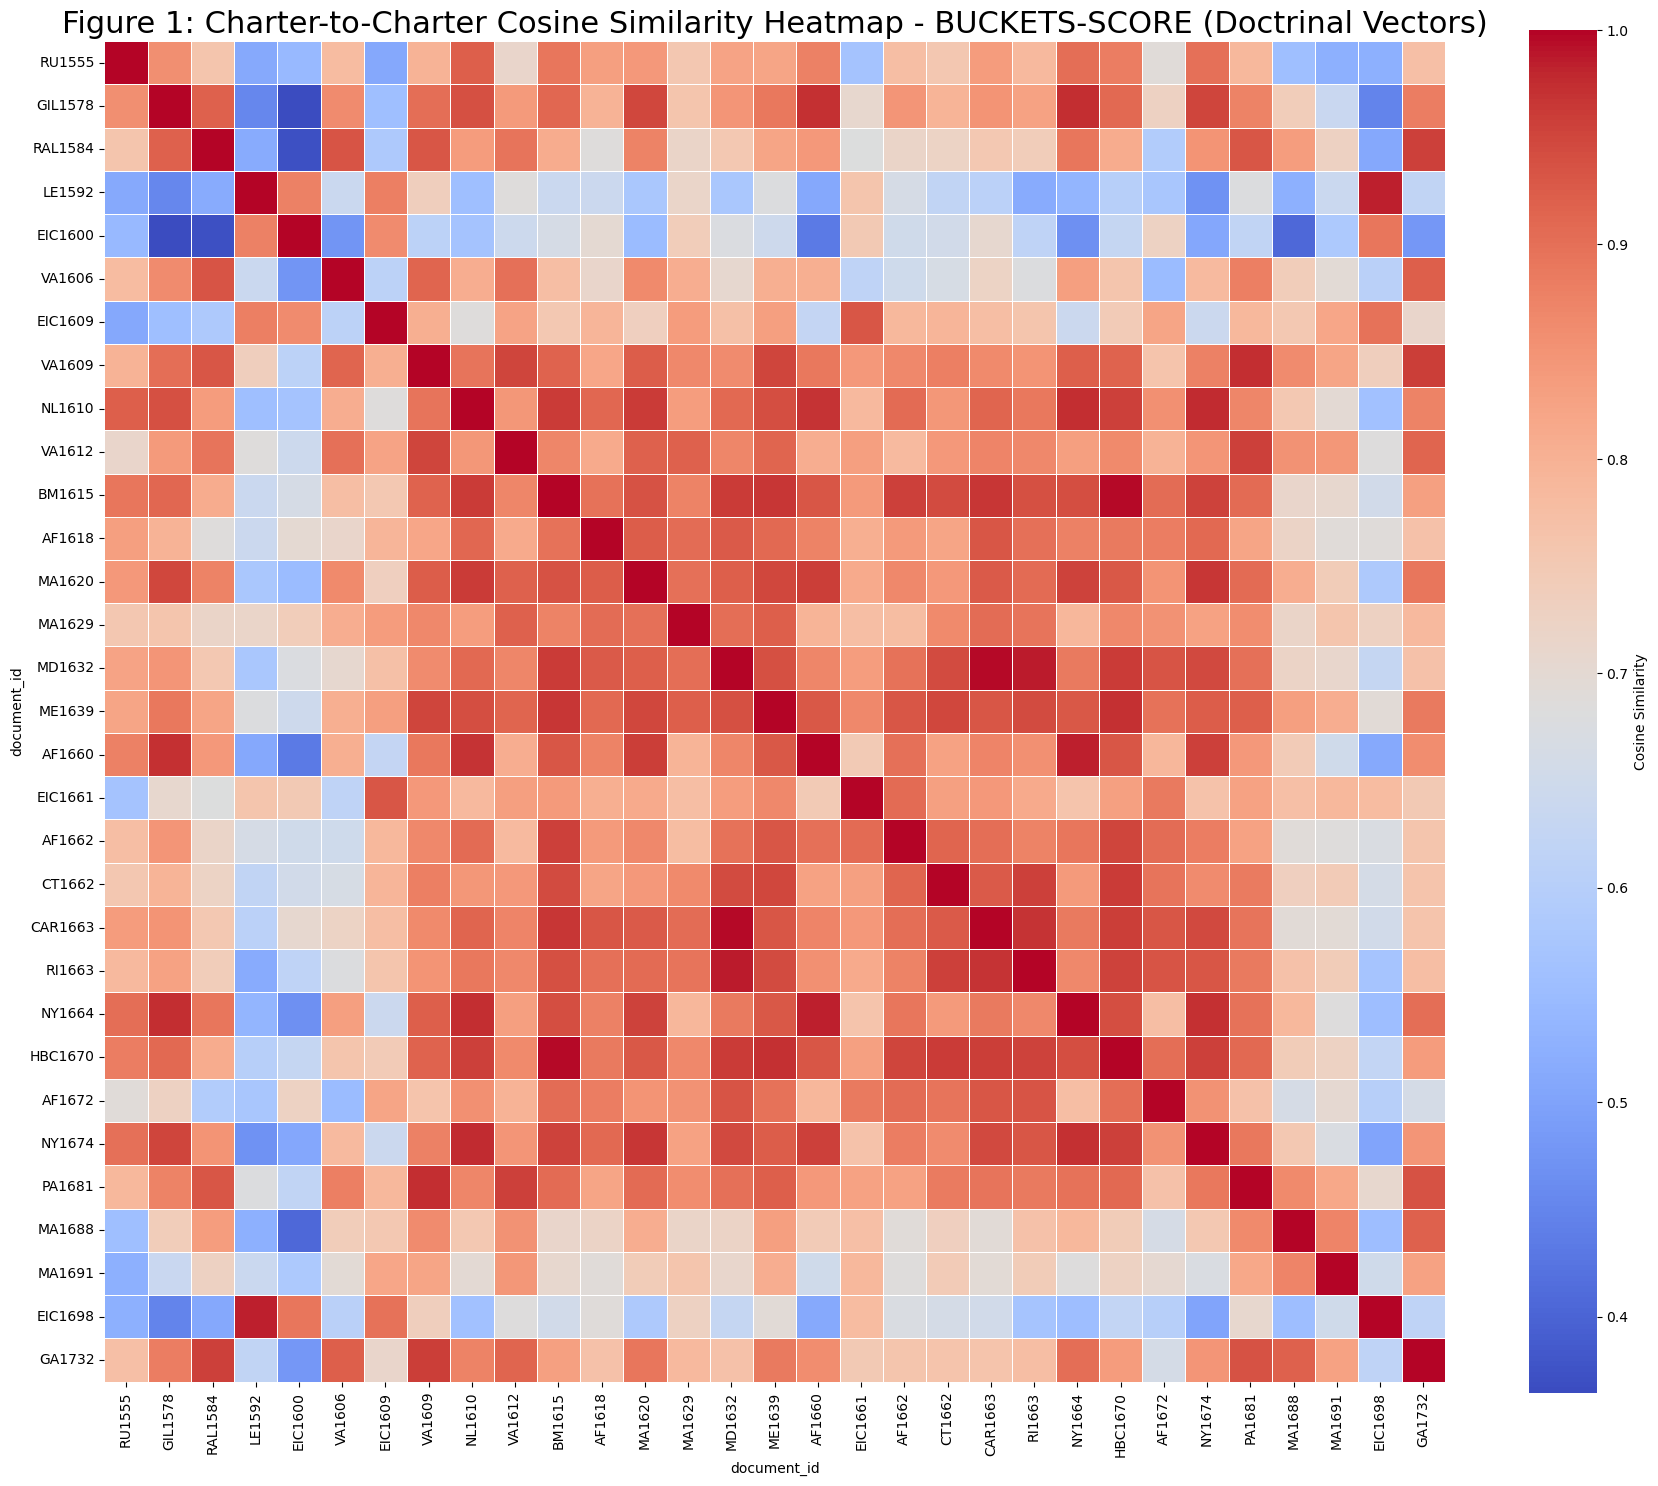

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Compute cosine similarity matrix
X = df_anaylsis.values
cos_sim_matrix = cosine_similarity(X)

# Step 2: Wrap in DataFrame for labeled axes
cos_sim_df = pd.DataFrame(
    cos_sim_matrix,
    index=df_anaylsis.index,
    columns=df_anaylsis.index
)

# Step 3: Plot the heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(
    cos_sim_df,
    xticklabels=cos_sim_df.index,
    yticklabels=cos_sim_df.index,
    cmap='coolwarm',
    square=True,
    #vmin=0,
    #vmax=1,
    cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.77},
    linewidths=0.5
)
plt.title("Figure 1: Charter-to-Charter Cosine Similarity Heatmap - BUCKETS-SCORE (Doctrinal Vectors)", fontsize=22)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


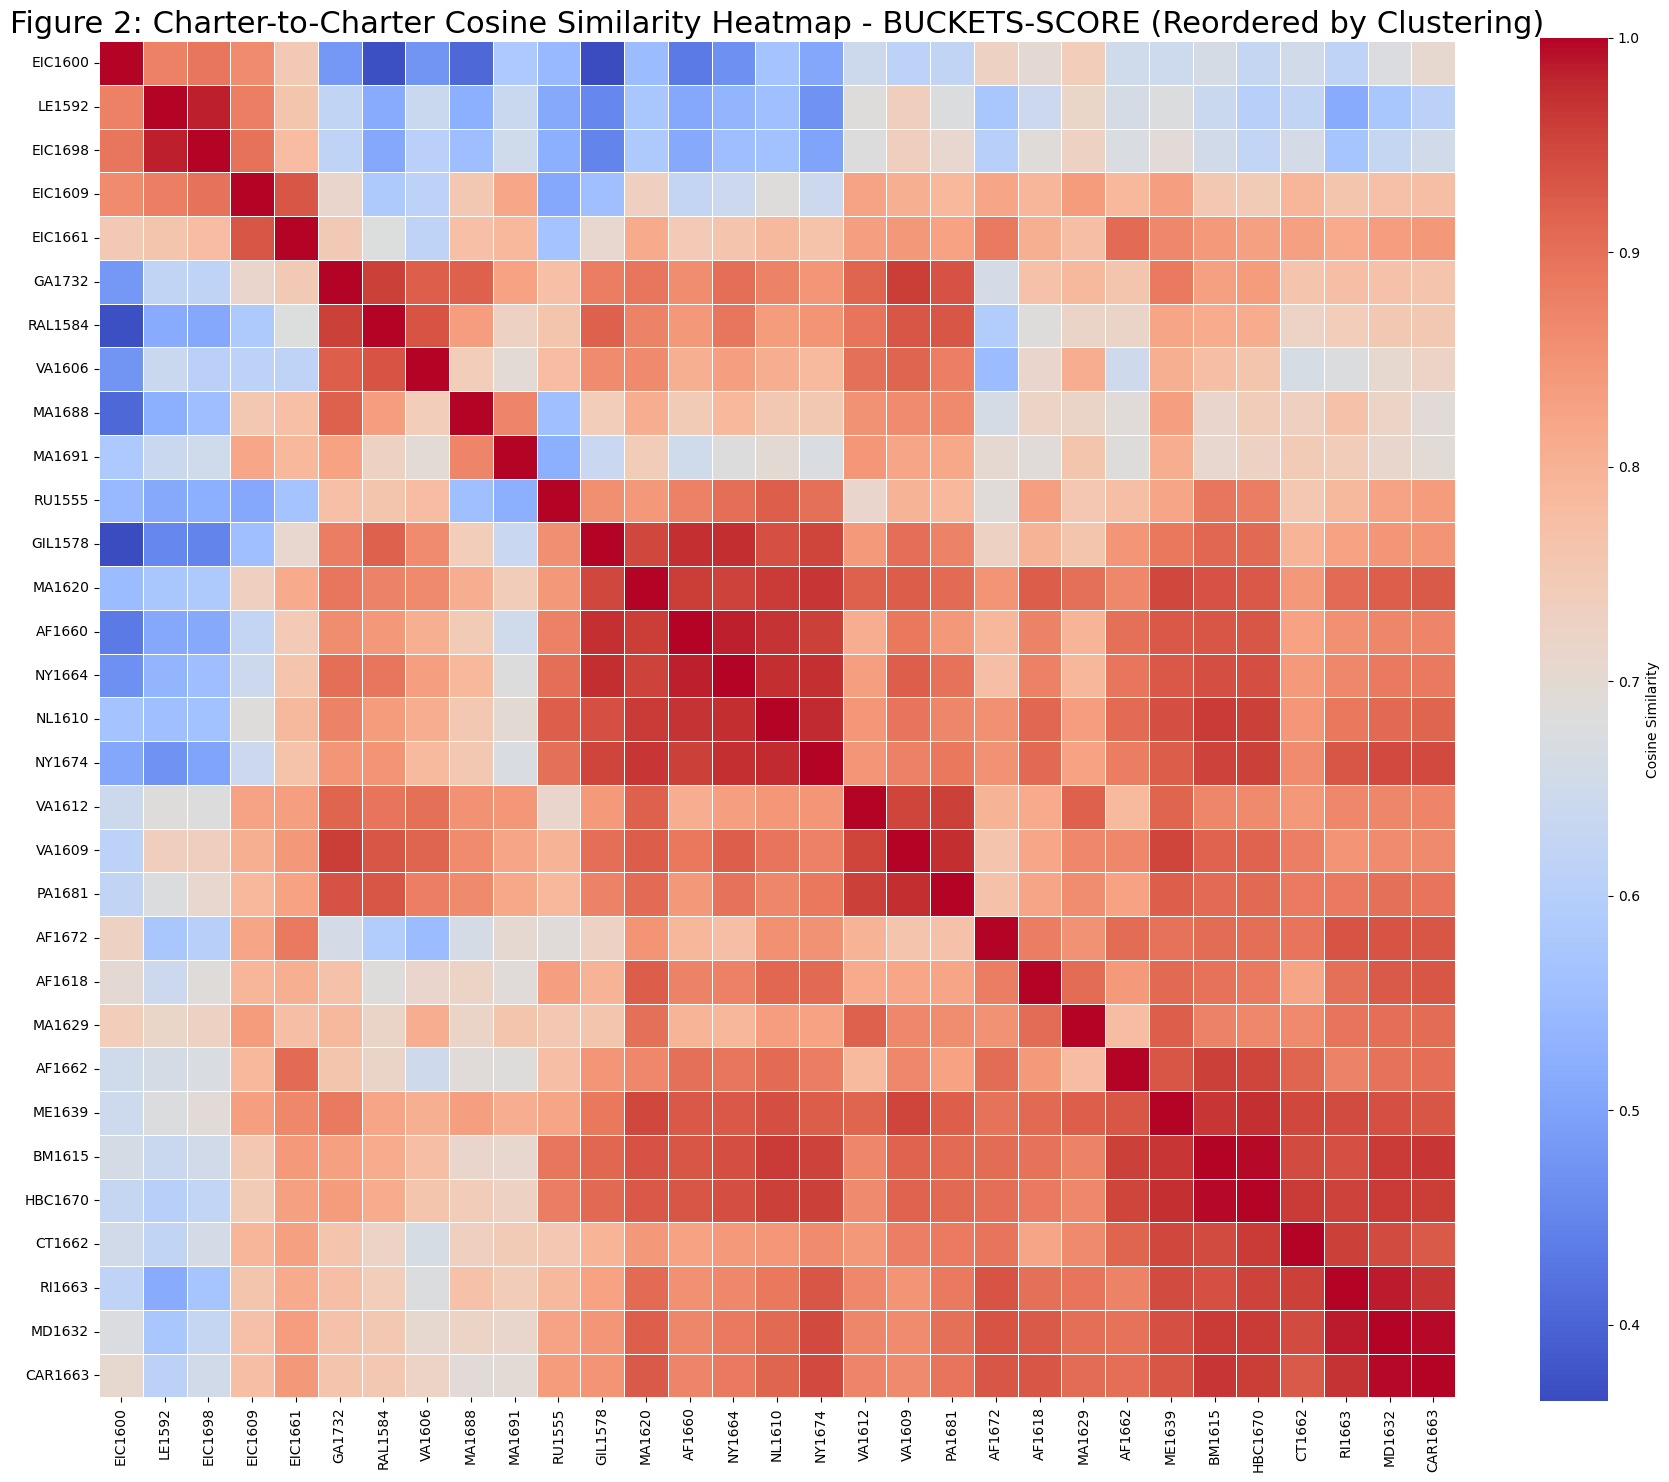

In [13]:
# Step 1: Extract doctrinal vectors
X = df_anaylsis.values

# Step 2: Compute cosine similarity
cos_sim_matrix = cosine_similarity(X)

# Step 3: Hierarchical clustering to get optimal order
linkage_matrix = linkage(1 - cos_sim_matrix, method='average')
optimal_order = leaves_list(linkage_matrix)

# Step 4: Reorder matrix and charter labels
ordered_matrix = cos_sim_matrix[np.ix_(optimal_order, optimal_order)]
ordered_labels = df_anaylsis.index[optimal_order].tolist()

# Step 5: Plot
plt.figure(figsize=(18, 18))
sns.heatmap(
    ordered_matrix,
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.77}
)
plt.title("Figure 2: Charter-to-Charter Cosine Similarity Heatmap - BUCKETS-SCORE (Reordered by Clustering)", fontsize=22)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


In [14]:
# Confirm same shape
assert cos_sim_matrix.shape == ordered_matrix.shape

# Confirm values are preserved by checking matrix equality after reordering
reverse_order = np.argsort(optimal_order)
recovered_matrix = ordered_matrix[np.ix_(reverse_order, reverse_order)]

assert np.allclose(cos_sim_matrix, recovered_matrix), "Cosine values changed!"


### Embedding Cosine Similarity - Charter Level (Binary variables level)

In [15]:
# Preparing the dataset for analysis

df_analysis_binary_vars = new_df.copy()

binary_vars_to_keep = [
    # 0. Document ID
    'document_id',

    # 1. Foundational / Legacy Clauses
    'prior_rights_savings_clause',

    # 2. Territorial & Settlement Rights
    'territorial_rights',
    'settlement_rights',
    'resource_rights',

    # 3. Governance & Legislative Powers
    'governance_rights',
    'lawmaking_rights',
    'lawmaking_participation_joint',

    # 4. Judicial & Disciplinary Powers
    'judicial_powers',
    'court_creation_rights',
    'disciplinary_jurisdiction',
    'martial_law_rights',

    # 5. Defense & Security
    'defense_rights',

    # 6. Economic & Commercial Rights
    'trade_rights',
    'fundraising_rights',
    'exemption_rights',

    # 7. Civil & Private Law Rights
    'civil_and_religious_rights',
    'property_rights',
    'litigation_rights',

    # 8. Corporate & Investor Rights
    'corporate_investor_rights',
    'exclusivity_rights',
    'legal_entity_rights',

    # 9. Voting & Representation
    'investor_voting_right',
    'settler_voting_rights',

    # 10. Officer & Personnel Rights
    'officer_appointment_rights',
    'officer_removal_rights',
    'office_oath_required',
    'oath_administration_rights',

    # 11. Membership Rights
    'membership_admission_rights',
    'membership_expulsion_rights',
    'corporate_oath_required',

    # 12. Delegation & Procedural Powers
    'delegation_rights',
    'procedural_powers',
    'veto_powers',
    'imposed_institutional_veto',

    # 13. Legal Interpretation & Transplantation
    'legal_transplantation',
    'favor_interpretation_ambiguity_grantee',

    # 14. Crown Obligations & Oversight
    'crown_obligation',
    'crown_oath_required',
    'royal_review_required',
    'crown_reservation',
    'royal_imposed_limitation',

    # 15. Institutional Autonomy & Limitation
    'institutional_autonomy_rights',
    'institutional_limitation',
    'limits_royal_prerogative',
    'subjection_to_english_law'
]

# Finally, keep only columns relevant for embedding analysis
df_analysis_binary_vars = df_analysis_binary_vars[binary_vars_to_keep]

df_analysis_binary_vars.set_index('document_id', inplace=True)

df_analysis_binary_vars.head()

,prior_rights_savings_clause,territorial_rights,settlement_rights,resource_rights,governance_rights,lawmaking_rights,lawmaking_participation_joint,judicial_powers,court_creation_rights,disciplinary_jurisdiction,...,favor_interpretation_ambiguity_grantee,crown_obligation,crown_oath_required,royal_review_required,crown_reservation,royal_imposed_limitation,institutional_autonomy_rights,institutional_limitation,limits_royal_prerogative,subjection_to_english_law
document_id,,,,,,,,,,,,,,,,,,,,,
RU1555,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GIL1578,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
RAL1584,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
LE1592,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
EIC1600,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


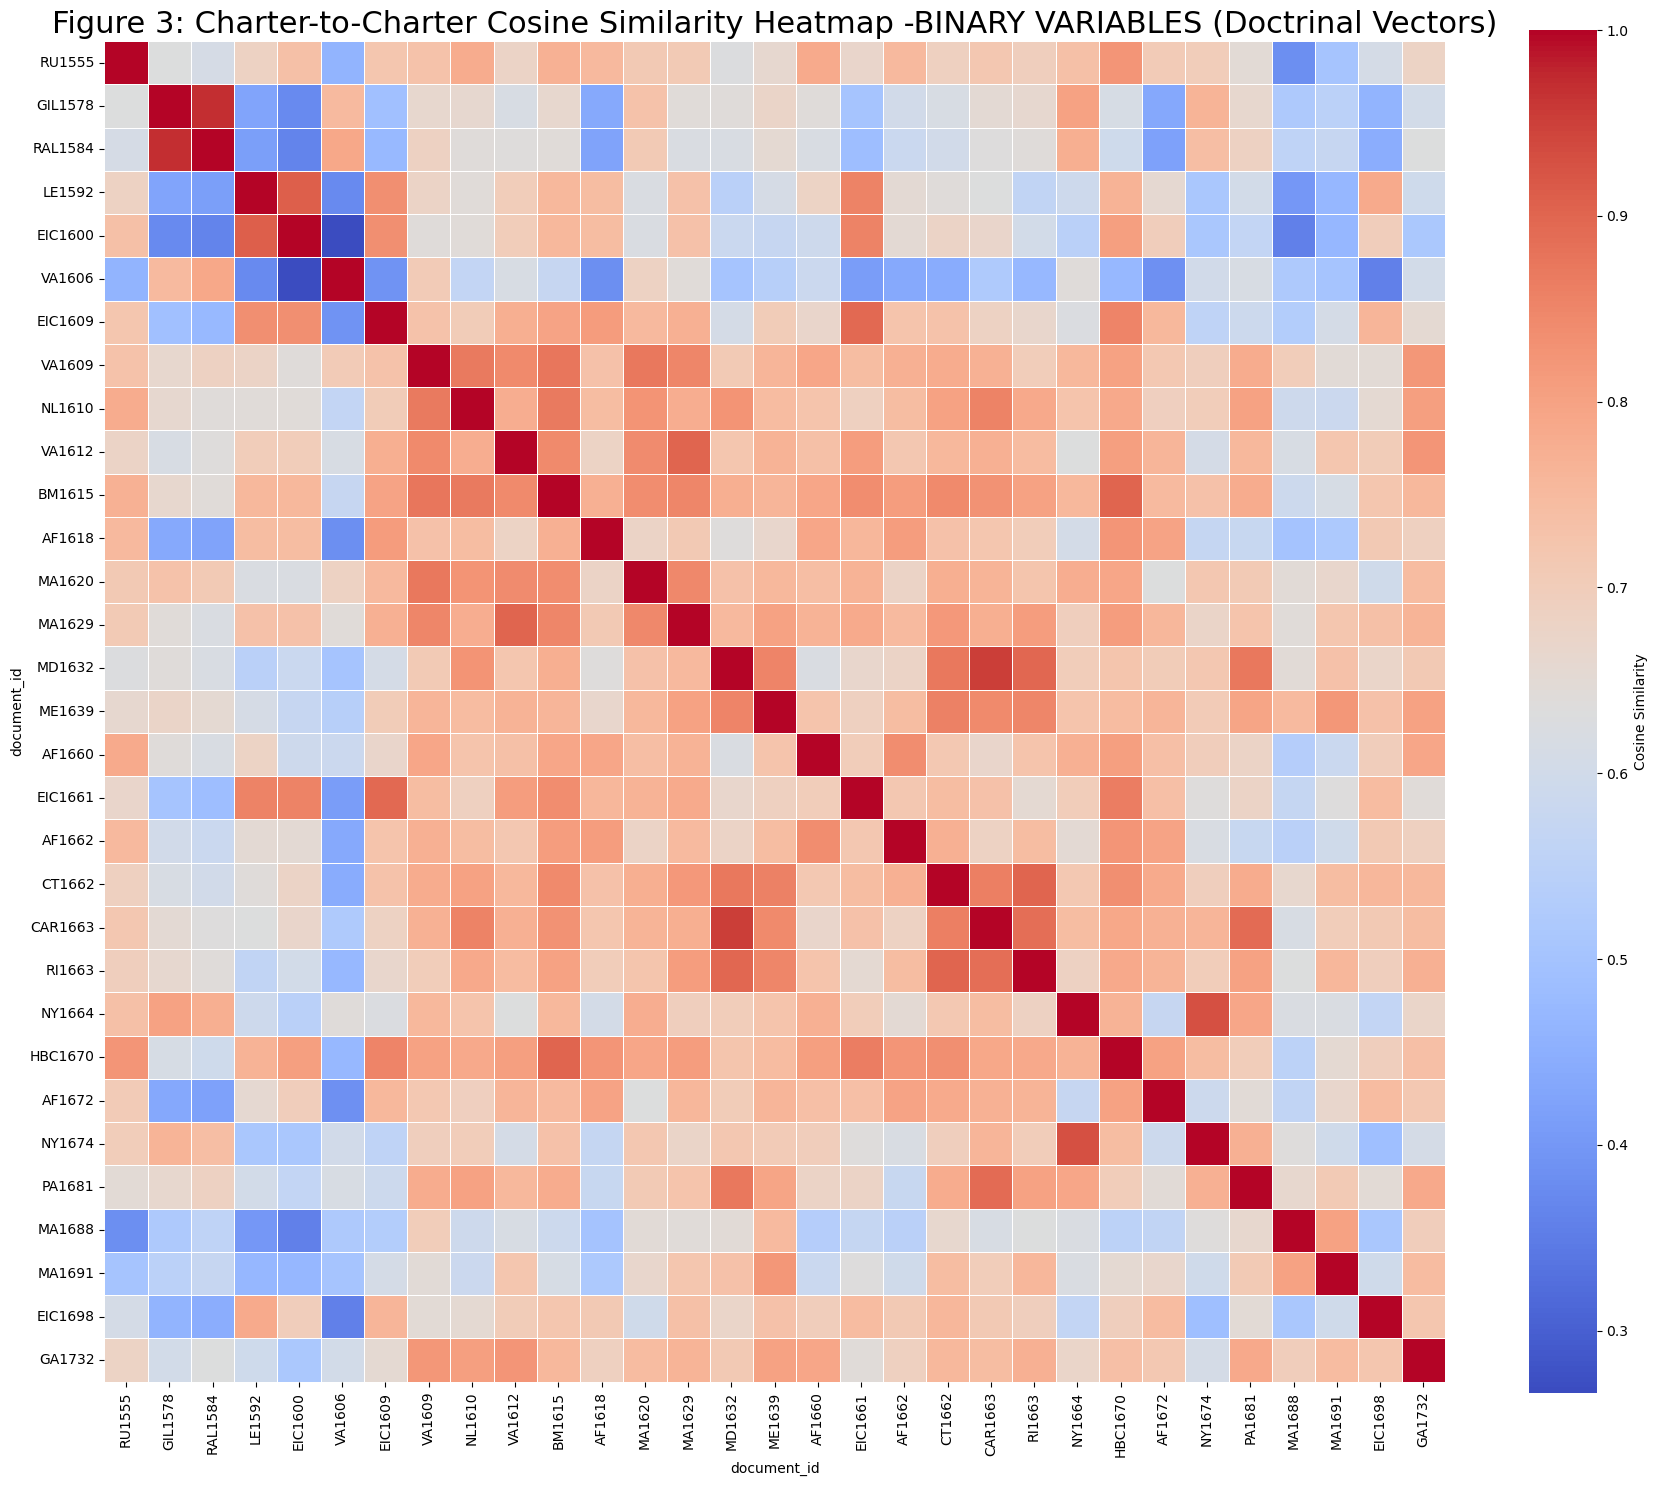

In [16]:
# Step 1: Compute cosine similarity matrix
X = df_analysis_binary_vars.values
cos_sim_matrix = cosine_similarity(X)

# Step 2: Wrap in DataFrame for labeled axes
cos_sim_df_binary = pd.DataFrame(
    cos_sim_matrix,
    index=df_analysis_binary_vars.index,
    columns=df_analysis_binary_vars.index
)

# Step 3: Plot the heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(
    cos_sim_df_binary,
    xticklabels=cos_sim_df_binary.index,
    yticklabels=cos_sim_df_binary.index,
    cmap='coolwarm',
    square=True,
    cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.77},
    linewidths=0.5
)
plt.title("Figure 3: Charter-to-Charter Cosine Similarity Heatmap -BINARY VARIABLES (Doctrinal Vectors)", fontsize=22)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

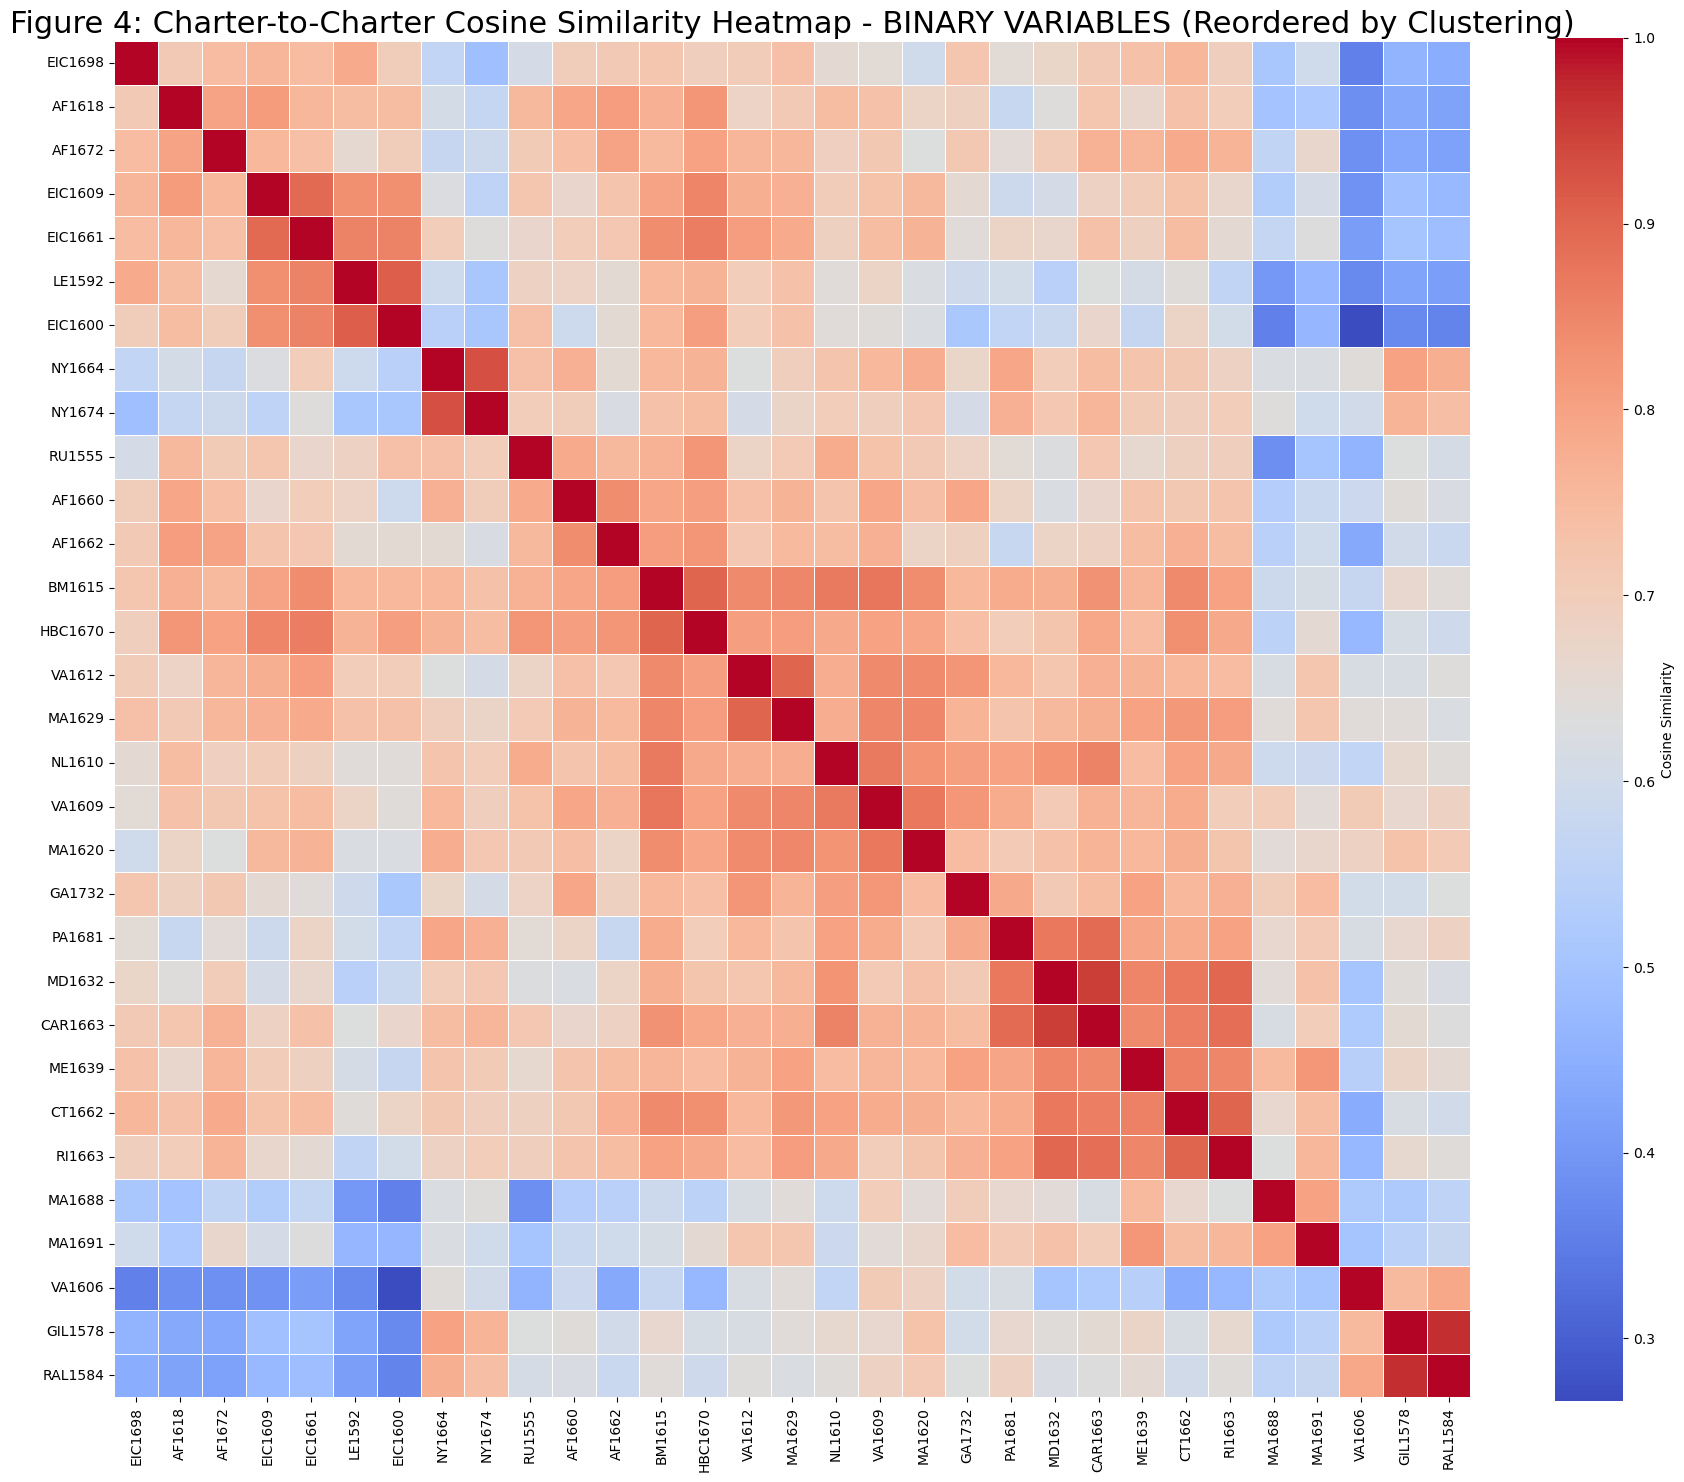

In [17]:
# Step 1: Extract doctrinal vectors
X = df_analysis_binary_vars.values

# Step 2: Compute cosine similarity
cos_sim_df_binary = cosine_similarity(X)

# Step 3: Hierarchical clustering to get optimal order
linkage_matrix = linkage(1 - cos_sim_df_binary, method='average')
optimal_order = leaves_list(linkage_matrix)

# Step 4: Reorder matrix and charter labels
ordered_matrix = cos_sim_df_binary[np.ix_(optimal_order, optimal_order)]
ordered_labels = df_anaylsis.index[optimal_order].tolist()

# Step 5: Plot
plt.figure(figsize=(18, 18))
sns.heatmap(
    ordered_matrix,
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cmap='coolwarm',
    square=True,    linewidths=0.5,
    cbar_kws={'label': 'Cosine Similarity', 'shrink': 0.77}
)
plt.title("Figure 4: Charter-to-Charter Cosine Similarity Heatmap - BINARY VARIABLES (Reordered by Clustering)", fontsize=22)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()
